In [1]:
%matplotlib inline

import os 
import glob 
import sys
sys.path.append('/home/ngr4/project/edge_feat/scripts')
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import utils
import load_data as data
import math
import numpy as np
import pandas as pd
import seaborn as sns
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import graphtools as gt
import phate
import umap
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import scanpy as sc
from scipy import sparse
import scprep
import time
import datetime
from scipy.stats import zscore
from adjustText import adjust_text


from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split

from captum.attr import (
#     GradientShap,
#     DeepLift,
#     DeepLiftShap,
    IntegratedGradients,
#     LayerConductance,
#     NeuronConductance,
    NoiseTunnel,
)



plt.rc('font', size = 8)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
sns.set_style("ticks")

In [135]:
# aesthetics
# cmap_timepoint = {v:sns.light_palette((210, 90, 60), input="husl")[1:][i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

cmap_timepoint = {v:sns.color_palette('BuGn')[1:][i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

cmap_genotime = {}
for g in ['WT', 'SCA1']:
    if g=='WT':
        for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk']):
            cmap_genotime['{}_{}'.format(g, v)] = sns.cubehelix_palette(5, start=.5, rot=-.75)[i]
    if g=='SCA1':
        for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk']):
            cmap_genotime['{}_{}'.format(g, v)] = sns.cubehelix_palette(5)[i]
            
cmap_ctype={'Granule cell': '#FAC18A',
            'Unipolar brush cell': '#BA61BA',
            'Purkinje cell': '#EE5264',
            'GABAergic interneuron 1': '#F9EBAE',
            'GABAergic interneuron 2': '#88BB92',
            'GABAergic interneuron 3': '#46A928',
            'Astrocyte': '#F9AEAE',
            'Bergmann glia': '#AEB7F9',
            'Oligodendrocyte progenitor cell': '#F1815F',
            'Oligodendrocyte': '#75A3B7',
            'Microglia': '#AC5861',
            'Pericyte': '#2D284B',
            'Endothelial cell': '#1C67EE',
            'Deep cerebellar nuclei': '#aaaaaa'}

cmap_genotype={'WT':'#010101',
               'SCA1':'#ffd478'}



In [3]:
def load_mouse(file='/home/ngr4/project/scnd/data/processed/mouse_210726.h5ad'):
    return sc.read(file)

In [4]:
adata = load_mouse()

In [5]:
class Encoder(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, s_max, d_model, num_heads, ln=False, skip=True):
        super(Encoder, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.skip = skip
        self.s_max = s_max
        #Maximum set size
        self.d_model = d_model
        self.fc_q = nn.Linear(dim_Q, d_model)
        self.fc_k = nn.Linear(dim_K, d_model)
        self.fc_v = nn.Linear(dim_K, d_model)
        if ln:
            self.ln0 = nn.LayerNorm(d_model)
            self.ln1 = nn.LayerNorm(d_model)
        #This is the classic pointwise feedforward in "Attention is All you need"
        self.ff = nn.Sequential(
        nn.Linear(d_model, 4 * d_model),
        nn.ReLU(),
        nn.Linear(4 * d_model, d_model))
        self.fc_rep = nn.Linear(s_max, 1)
        
    # number of heads must divide output size = d_model
    def forward(self, Q, K, return_attention, return_A):
        Q = self.fc_q(Q)
        K, V = self.fc_k(K), self.fc_v(K)
        dim_split = self.d_model // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)
        A = torch.softmax(Q_.bmm(K_.transpose(-2,-1))/math.sqrt(self.d_model), dim=-1)
        A_1 = A.bmm(V_) 
        O = torch.cat((A_1).split(Q.size(0), 0), 2) 
        if return_attention:
            attn = O
        O = torch.cat((Q_ + A_1).split(Q.size(0), 0), 2) if getattr(self, 'skip', True) else \
             torch.cat((A_1).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)

        # For the classic transformers paper it is
        O = O + self.ff(O)
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        O = O.transpose(-2,-1)
        O = F.pad(O, (0, self.s_max- O.shape[-1]), 'constant', 0)
        O = self.fc_rep(O)
        O = O.squeeze() 
        if return_attention:
            return O, attn
        elif return_A:
            return O, A
        else:
            return O
    
class SelfAttention_batch(nn.Module):
    def __init__(self, s_max, dim_in=18, dim_out=8, num_heads=2, ln=True, skip=True):
        super(SelfAttention_batch, self).__init__()
        self.Encoder = Encoder(dim_in, dim_in, dim_in, s_max, dim_out, num_heads, ln=ln, skip=skip)
        
    def forward(self, X, return_attention=True, return_A=False):
        return self.Encoder(X, X, return_attention, return_A)
    
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.gat1 = data.GATConv(d.num_node_features, out_channels=8,
                                 heads=8, concat=True, negative_slope=0.2,
                                 dropout=0.4, bias=True)
        self.gat2 = data.GATConv(8*8, out_channels=d.y.unique().size()[0],
                                 heads=8, concat=False, negative_slope=0.2,
                                 dropout=0.4, bias=True)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x, attn_gat1 = self.gat1(x, edge_index)
        hprime = x # store embeddings 
        x = F.elu(x)
        x, attn_gat2 = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1), attn_gat1, attn_gat2, hprime
    
    
class GAT_transformer_mlp_batch(torch.nn.Module):
    def __init__(self):
        super(GAT_transformer_mlp_batch, self).__init__()
        self.gat1 = data.GATConv(d.num_node_features, out_channels=8,
                                 heads=8, concat=True, negative_slope=0.2,
                                 dropout=0.4, bias=True)
        self.gat2 = data.GATConv(8*8, out_channels=8,
                                 heads=8, concat=True, negative_slope=0.2,
                                 dropout=0.4, bias=True)
        self.transformer = SelfAttention_batch(s_max)
        self.linear = nn.Linear(72, d.y.unique().size()[0])

    def forward(self, data, edge_feats):
        x, edge_index = data.x, data.edge_index
        x, attn_gat1 = self.gat1(x, edge_index)
        x = F.elu(x)
        x_t, attn_trans = self.transformer(edge_feats)
        x, attn_gat2 = self.gat2(x, edge_index)
        x = self.linear(torch.cat((x,x_t),dim=1))
        return F.log_softmax(x, dim=1), attn_trans, attn_gat1, attn_gat2
    
class GCN_transformer_mlp_batch(torch.nn.Module):
    def __init__(self):
        super(GCN_transformer_mlp_batch, self).__init__()
        self.conv1 = GCNConv(d.num_node_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.transformer = SelfAttention_batch(s_max)
        self.linear = nn.Linear(72, d.y.unique().size()[0])

    def forward(self, data, edge_feats):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x_t, attn_trans = self.transformer(edge_feats)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.linear(torch.cat((x,x_t),dim=1))
        return F.log_softmax(x, dim=1), attn_trans
    
    
# other utils fx 
def load_pkl(fname):
    with open(fname, 'rb') as f:
        data = pickle.load(f)
        f.close()
    return data

def adata_phate(adata):
    # compute PHATE
    G = gt.Graph(data=adata.obsp['connectivities']+sparse.diags([1]*adata.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
    G.knn_max = None
    
    phate_op = phate.PHATE(knn_dist='precomputed',
                           gamma=0,
                           random_state=42)
    adata.obsm['X_phate']=phate_op.fit_transform(G.K)
    
    return adata

In [6]:
def main(d, **kwargs):
    
    batch_it = False 
    
    if 'trans' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
        s_max = kwargs['s_max']
        if 'gcn' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
            model = GCN_transformer_mlp_batch()
        elif 'gat' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
            model = GAT_transformer_mlp_batch()
    elif 'GAT'== kwargs['model']:
        model = GAT()
    model.eval()
    model.load_state_dict(torch.load(kwargs['modeleval_pkl'], map_location=torch.device('cpu')))
    
    if batch_it:
        # TODO: not implemented for GCN 
        cd_test = data.ClusterData(d,5000)
        cl_test = data.ClusterLoader(cd_test,256,shuffle=True)

        batch_loss_test = []
        batch_acc_test = []

        for batch in cl_test:
            output, attn_trans, attn_gat1, attn_gat2 = model(batch, utils.edge_set_reshape(batch).float())
            loss_test = F.nll_loss(output, batch.y)
            batch_acc_test.append(utils.accuracy(output,batch.y).item())
            batch_loss_test.append(loss_test.item())
        print('Test set results:')
        print('  <loss>_bacth={:.4f}'.format(np.mean(batch_loss_test)))
        print('  <acc>_batch ={:.4f}'.format(np.mean(batch_acc_test)))
    else:
        if 'trans' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
            if 'gcn' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
                output, attn_trans = model(d, utils.edge_set_reshape(d).float())
            elif 'gat' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
                output, attn_trans, attn_gat1, attn_gat2 = model(d, utils.edge_set_reshape(d).float())
        elif 'GAT'== kwargs['model']:
            output, attn_gat1, attn_gat2, hprime = model(d)
        loss_test = F.nll_loss(output, d.y)
        acc_test = utils.accuracy(output,d.y).item()
        print('Test set results:')
        print('  loss: {:.4f}'.format(loss_test))
        print('  accuracy: {:.4f}'.format(acc_test))
        
    datapkl = load_pkl(kwargs['data_pkl'])
    if 'trans' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
        return attn_gat1, attn_trans, datapkl, model, output # returns for only one batch if batch_it = True
    elif 'GAT'== kwargs['model']:
        return attn_gat1, attn_gat2, datapkl, model, output, hprime # returns for only one batch if batch_it = True

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def ss(x):
    """Sum of squares divided by sqrt N."""
    return np.sum(x**2)/np.sqrt(x.shape[0])

In [7]:
# modify 

pfp = '/home/ngr4/project/scnd/results'
pdfp = '/home/ngr4/project/scnd/data/processed'

featnames = load_pkl(os.path.join(pdfp,'scnd_feat_names.pkl'))

params = { 
        
        ################################################################################
        # modify
        ################################################################################
        'modeleval_pkl':'/home/ngr4/project/edge_feat/scripts/hbec/inftime_gattransmlpbatch/581-hbec_it_gattransmlpbatch1.pkl',
        'data_pkl':'/home/ngr4/project/sccovid/data/processed/hbec_test_200529.pkl',
        'sample':'hbec_it_gattransmlpbatch',
        's_max': 36, # get from log, 
        'label':'yinftime',
        'model':'GCN_transformer_mlp_batch', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':'yctype', # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':'/home/ngr4/project/sccovid/data/processed/338-hbec_ctype_gat1.pkl', # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':'ybatch',
        'modelpkl_fname2':'/home/ngr4/project/sccovid/data/processed/1148-hbec_batch_gat1.pkl',
        'preloadn2v':True, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################
        
    }

params_gcn = { 
        
        ################################################################################
        # modify
        ################################################################################
        'modeleval_pkl':'/home/ngr4/project/edge_feat/scripts/hbec/inftime_gcntransmlpbatch/705-hbec_gt_gcntransmlpbatch1.pkl',
        'data_pkl':'/home/ngr4/project/sccovid/data/processed/hbec_test_200529.pkl',
        'sample':'hbec_it_gcntransmlpbatch',
        's_max': 41, # get from log, 
        'label':'yinftime',
        'model':'GCN_transformer_mlp_batch', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':'yctype', # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':'/home/ngr4/project/sccovid/data/processed/338-hbec_ctype_gat1.pkl', # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':'ybatch',
        'modelpkl_fname2':'/home/ngr4/project/sccovid/data/processed/1148-hbec_batch_gat1.pkl',
        'preloadn2v':True, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################
        
    }

params5wk = {

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/SCA1_5wk/151-scnd1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'SCA1_5wk',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params12wk = {

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/SCA1_12wk/138-scnd1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'SCA1_12wk',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params18wk = {

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/SCA1_18wk/81-scnd1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'SCA1_18wk',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params24wk = {

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/SCA1_24wk/224-scnd1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'SCA1_24wk',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params30wk = {

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/SCA1_30wk/72-scnd1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'SCA1_30wk',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params_sca1 = {

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/SCA1/51-scnd1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'ysca1',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params_gt = { #genotime

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/genotype_time/584-scnd_gt1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'ygenotime',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }



### Integrated gradients for WT v. MUT

In [8]:
# modify class
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.gat1 = data.GATConv(d.num_node_features, out_channels=8,
                                 heads=8, concat=True, negative_slope=0.2,
                                 dropout=0.4, bias=True)
        self.gat2 = data.GATConv(8*8, out_channels=d.y.unique().size()[0],
                                 heads=8, concat=False, negative_slope=0.2,
                                 dropout=0.4, bias=True)

    def forward(self, x, edge_index):
#         x, edge_index = data.x, data.edge_index
        x, attn_gat1 = self.gat1(x, edge_index)
        hprime = x # store embeddings 
        x = F.elu(x)
        x, attn_gat2 = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)
    
    
def main(d, **kwargs):
    
    batch_it = False 
    
    if 'trans' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
        s_max = kwargs['s_max']
        if 'gcn' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
            model = GCN_transformer_mlp_batch()
        elif 'gat' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
            model = GAT_transformer_mlp_batch()
    elif 'GAT'== kwargs['model']:
        model = GAT()
    model.eval()
    model.load_state_dict(torch.load(kwargs['modeleval_pkl'], map_location=torch.device('cpu')))
    
    if batch_it:
        # TODO: not implemented for GCN 
        cd_test = data.ClusterData(d,5000)
        cl_test = data.ClusterLoader(cd_test,256,shuffle=True)

        batch_loss_test = []
        batch_acc_test = []

        for batch in cl_test:
            output, attn_trans, attn_gat1, attn_gat2 = model(batch, utils.edge_set_reshape(batch).float())
            loss_test = F.nll_loss(output, batch.y)
            batch_acc_test.append(utils.accuracy(output,batch.y).item())
            batch_loss_test.append(loss_test.item())
        print('Test set results:')
        print('  <loss>_bacth={:.4f}'.format(np.mean(batch_loss_test)))
        print('  <acc>_batch ={:.4f}'.format(np.mean(batch_acc_test)))
    else:
        if 'trans' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
            if 'gcn' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
                output, attn_trans = model(d, utils.edge_set_reshape(d).float())
            elif 'gat' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
                output, attn_trans, attn_gat1, attn_gat2 = model(d, utils.edge_set_reshape(d).float())
        elif 'GAT'== kwargs['model']:
            output = model(d.x, d.edge_index)
        loss_test = F.nll_loss(output, d.y)
        acc_test = utils.accuracy(output,d.y).item()
        print('Test set results:')
        print('  loss: {:.4f}'.format(loss_test))
        print('  accuracy: {:.4f}'.format(acc_test))
        
    datapkl = load_pkl(kwargs['data_pkl'])
    if 'trans' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
        return attn_gat1, attn_trans, datapkl, model, output # returns for only one batch if batch_it = True
    elif 'GAT'== kwargs['model']:
        return datapkl, model, output # returns for only one batch if batch_it = True

def custom_forward(x, edge_index):
    return model(x.squeeze(), edge_index[0])

In [9]:
# load model
for params in [params_sca1]:
    kwargs = params
    d = data.get_data(kwargs['data_pkl'], kwargs['label'], 
                           kwargs['sample'], None, 
                           kwargs['load_attn1'], kwargs['load_attn2'],
                           kwargs['modelpkl_fname1'], kwargs['modelpkl_fname2'],
                           kwargs['preloadn2v'], out_channels=8, 
                           heads=8, negative_slope=0.2, 
                           dropout=0.4)
    s_max = kwargs['s_max'] # scope is incorrect when in fx
    datapkl, model, output = main(d, **kwargs) # attn_trans, attn_gat1, datapkl, model IF transformer eval
    
    # print various metrics 
    y_true = datapkl[kwargs['label']]
    p1 = np.exp(output.detach().numpy()[:,1])
    fpr, tpr, thresholds = metrics.roc_curve(y_true, p1)
    optimal_idx = np.argmax(tpr-fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_pred = (p1>optimal_threshold).astype(int)
    precision,recall,_ = metrics.precision_recall_curve(y_true, p1)
    auprc = metrics.auc(recall, precision)
    auroc = metrics.roc_auc_score(y_true,p1)
    ap = metrics.average_precision_score(y_true,p1)
    bs = metrics.brier_score_loss(y_true,p1)
    f1 = metrics.f1_score(y_true,optimal_pred)
    acc = metrics.accuracy_score(y_true,optimal_pred)

    print('{} results'.format(kwargs['label']))
    print('-----------------------')
    print('Accuracy      : {:.4f}'.format(acc))
    print('Sensitivity   : {:.4f}'.format(tpr[optimal_idx]))
    print('Specificity   : {:.4f}'.format(1-fpr[optimal_idx]))
    print('')
    print('Ave. precision: {:.4f}'.format(ap))
    print('Precision     : {:.4f}'.format(1-precision[optimal_idx])) # not sure about this
    print('Recall        : {:.4f}'.format(recall[optimal_idx])) # not sure about this
    print('')
    print('AU-ROC        : {:.4f}'.format(auroc))
    print('AU-PRC        : {:.4f}'.format(auprc))
    print('Brier         : {:.4f}'.format(bs))
    print('F1            : {:.4f}'.format(f1))
    
    # check confusion matrix 
    print('\nConfusion matrix: (i-th truth, j-th pred)')
    print(metrics.confusion_matrix(y_true, optimal_pred))

node2vec model fitting...


Generating walks (CPU: 1): 100%|██████████| 10/10 [16:39<00:00, 99.96s/it]


  embeddings calculated in 1564.0-s
Dot prod per 1041623 edges

Data shapes:
Data(edge_attr=[1041623, 1], edge_index=[2, 1041623], x=[21327, 26374], y=[21327])

Test set results:
  loss: 0.3733
  accuracy: 0.8386
ysca1 results
-----------------------
Accuracy      : 0.8393
Sensitivity   : 0.8430
Specificity   : 0.8359

Ave. precision: 0.9203
Precision     : 0.4328
Recall        : 0.9894

AU-ROC        : 0.9154
AU-PRC        : 0.9203
Brier         : 0.1174
F1            : 0.8342

Confusion matrix: (i-th truth, j-th pred)
[[9274 1821]
 [1607 8625]]


In [10]:
# sex
batch2sex = {
    '1589': 'M',
     '1974': 'M',
     '2020': 'F',
     '20202': 'F',
     '2021': 'F',
     '20212': 'F',
     '2061': 'M',
     '2062': 'M',
     '2063': 'M',
     '2065': 'M',
     '22018': 'M',
     '22019': 'M',
     '5812': 'F',
     '5822': 'F',
     '58231': 'F',
     '58232': 'F',
     '58241': 'F',
     '58242': 'F',
     '6569': 'M',
     '65701': 'M',
     '65702': 'M',
     '6571': 'M',
     '65731': 'M',
     '65732': 'M',
     '7202': 'F',
     '72921': 'M',
     '72922': 'M',
     '72931': 'M',
     '72932': 'M',
     '7294': 'F'
}

adata.obs['sex'] = adata.obs['batch'].map(batch2sex)
adata.obs['Female'] = 0
adata.obs.loc[adata.obs['sex']=='F', 'Female'] = 1

# map to datapkl
datapkl['female'] = [adata.obs.loc[cell_id, 'Female'] for cell_id in datapkl['cell_id']]
datapkl['ctype_ubcupdate'] = [adata.obs.loc[cell_id, 'ctype_ubcupdate'] for cell_id in datapkl['cell_id']]

In [141]:
md.ctype.unique()

array(['Granule cell', 'Bergmann glia', 'Deep cerebellar nuclei',
       'Astrocyte', 'Pericyte', 'Microglia', 'GABAergic interneuron 2',
       'Oligodendrocyte', 'Endothelial cell', 'Purkinje cell',
       'GABAergic interneuron 3', 'GABAergic interneuron 1',
       'Oligodendrocyte progenitor cell', 'Unipolar brush cell'],
      dtype=object)

In [142]:
tic = time.time()

ig = IntegratedGradients(custom_forward)
nt = NoiseTunnel(ig)

# for gtype, timepoint, ctype --> get importance scores by averaging expression in that group
md = pd.DataFrame({'genotype':datapkl['genotype'],
                  'timepoint':datapkl['timepoint'],
                  'ctype':datapkl['ctype_ubcupdate'],
                  'female':datapkl['female'],
                  'n_idx':list(range(len(datapkl['cell_id'])))},
                  index=datapkl['cell_id'])

ignt = pd.DataFrame() 
counter = 0
for i in ['SCA1']:#np.unique(datapkl['genotype']): # only select label group or average altogether?
    for j in np.unique(md['timepoint']):
        for k in np.unique(md['ctype']):
            for l in [0, 1]:
                idx = md.loc[(md['genotype']==i) & (md['timepoint']==j) & (md['ctype']==k) & (md['female']==l), 'n_idx'].to_list()
                print('starting n={} cells from {}, {}, {}, {}'.format(len(idx), i, j, k, l))
                if len(idx)==0:
                    print('No cells for {}, {}, {}, {}'.format(i,j,k,l))
                    continue
                X = torch.tensor(np.mean(np.asarray(datapkl['X'])[idx, :], axis=0)).unsqueeze(0)
                attr = nt.attribute(X, 
                                    additional_forward_args=((torch.tensor([0,0]).unsqueeze(0))), 
                                    nt_type='smoothgrad',  
                                    n_samples=10, 
                                    target=1)
                dt = pd.DataFrame({'ig+nt':attr.squeeze().numpy(), 
                                   'Gene':featnames})
                dt['genotype'] = i
                dt['timepoint'] = j
                dt['ctype'] = k
                dt['female'] = l
                wt_idx = md.loc[(md['genotype']=='WT') & (md['timepoint']==j) & (md['ctype']==k) & (md['female']==l), 'n_idx'].to_list()
                if len(wt_idx)==0:
                    print('No cells for {}, {}, {}'.format('WT',j,k))
                    continue
                emd = scprep.stats.differential_expression(np.asarray(datapkl['X'])[idx, :],
                                         np.asarray(datapkl['X'])[wt_idx, :],
                                       measure = 'emd',
                                       direction='both', 
                                       gene_names=featnames,
                                       n_jobs=-1).reset_index().rename(columns={'index':'Gene'})
                dt = dt.merge(emd, left_on='Gene', right_on='Gene')
                ignt = ignt.append(dt, ignore_index=True)
                print('  through {} iteration. {:.1f}-min elapsed'.format(counter+1, (time.time() - tic)/60))
                counter += 1
                
            

starting n=20 cells from SCA1, 12wk, Astrocyte, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 1 iteration. 0.1-min elapsed
starting n=0 cells from SCA1, 12wk, Astrocyte, 1
No cells for SCA1, 12wk, Astrocyte, 1
starting n=38 cells from SCA1, 12wk, Bergmann glia, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 2 iteration. 0.1-min elapsed
starting n=0 cells from SCA1, 12wk, Bergmann glia, 1
No cells for SCA1, 12wk, Bergmann glia, 1
starting n=3 cells from SCA1, 12wk, Deep cerebellar nuclei, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 3 iteration. 0.2-min elapsed
starting n=0 cells from SCA1, 12wk, Deep cerebellar nuclei, 1
No cells for SCA1, 12wk, Deep cerebellar nuclei, 1
starting n=4 cells from SCA1, 12wk, Endothelial cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 4 iteration. 0.3-min elapsed
starting n=0 cells from SCA1, 12wk, Endothelial cell, 1
No cells for SCA1, 12wk, Endothelial cell, 1
starting n=60 cells from SCA1, 12wk, GABAergic interneuron 1, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 5 iteration. 0.3-min elapsed
starting n=0 cells from SCA1, 12wk, GABAergic interneuron 1, 1
No cells for SCA1, 12wk, GABAergic interneuron 1, 1
starting n=15 cells from SCA1, 12wk, GABAergic interneuron 2, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 6 iteration. 0.4-min elapsed
starting n=0 cells from SCA1, 12wk, GABAergic interneuron 2, 1
No cells for SCA1, 12wk, GABAergic interneuron 2, 1
starting n=5 cells from SCA1, 12wk, GABAergic interneuron 3, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 7 iteration. 0.4-min elapsed
starting n=0 cells from SCA1, 12wk, GABAergic interneuron 3, 1
No cells for SCA1, 12wk, GABAergic interneuron 3, 1
starting n=1095 cells from SCA1, 12wk, Granule cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 8 iteration. 0.5-min elapsed
starting n=0 cells from SCA1, 12wk, Granule cell, 1
No cells for SCA1, 12wk, Granule cell, 1
starting n=4 cells from SCA1, 12wk, Microglia, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 9 iteration. 0.6-min elapsed
starting n=0 cells from SCA1, 12wk, Microglia, 1
No cells for SCA1, 12wk, Microglia, 1
starting n=32 cells from SCA1, 12wk, Oligodendrocyte, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 10 iteration. 0.6-min elapsed
starting n=0 cells from SCA1, 12wk, Oligodendrocyte, 1
No cells for SCA1, 12wk, Oligodendrocyte, 1
starting n=5 cells from SCA1, 12wk, Oligodendrocyte progenitor cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 11 iteration. 0.7-min elapsed
starting n=0 cells from SCA1, 12wk, Oligodendrocyte progenitor cell, 1
No cells for SCA1, 12wk, Oligodendrocyte progenitor cell, 1
starting n=3 cells from SCA1, 12wk, Pericyte, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 12 iteration. 0.7-min elapsed
starting n=0 cells from SCA1, 12wk, Pericyte, 1
No cells for SCA1, 12wk, Pericyte, 1
starting n=6 cells from SCA1, 12wk, Purkinje cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 13 iteration. 0.8-min elapsed
starting n=0 cells from SCA1, 12wk, Purkinje cell, 1
No cells for SCA1, 12wk, Purkinje cell, 1
starting n=4 cells from SCA1, 12wk, Unipolar brush cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 14 iteration. 0.9-min elapsed
starting n=0 cells from SCA1, 12wk, Unipolar brush cell, 1
No cells for SCA1, 12wk, Unipolar brush cell, 1
starting n=131 cells from SCA1, 18wk, Astrocyte, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 15 iteration. 0.9-min elapsed
starting n=0 cells from SCA1, 18wk, Astrocyte, 1
No cells for SCA1, 18wk, Astrocyte, 1
starting n=134 cells from SCA1, 18wk, Bergmann glia, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 16 iteration. 1.0-min elapsed
starting n=0 cells from SCA1, 18wk, Bergmann glia, 1
No cells for SCA1, 18wk, Bergmann glia, 1
starting n=10 cells from SCA1, 18wk, Deep cerebellar nuclei, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 17 iteration. 1.0-min elapsed
starting n=0 cells from SCA1, 18wk, Deep cerebellar nuclei, 1
No cells for SCA1, 18wk, Deep cerebellar nuclei, 1
starting n=36 cells from SCA1, 18wk, Endothelial cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 18 iteration. 1.1-min elapsed
starting n=0 cells from SCA1, 18wk, Endothelial cell, 1
No cells for SCA1, 18wk, Endothelial cell, 1
starting n=200 cells from SCA1, 18wk, GABAergic interneuron 1, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 19 iteration. 1.2-min elapsed
starting n=0 cells from SCA1, 18wk, GABAergic interneuron 1, 1
No cells for SCA1, 18wk, GABAergic interneuron 1, 1
starting n=58 cells from SCA1, 18wk, GABAergic interneuron 2, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 20 iteration. 1.2-min elapsed
starting n=0 cells from SCA1, 18wk, GABAergic interneuron 2, 1
No cells for SCA1, 18wk, GABAergic interneuron 2, 1
starting n=18 cells from SCA1, 18wk, GABAergic interneuron 3, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 21 iteration. 1.3-min elapsed
starting n=0 cells from SCA1, 18wk, GABAergic interneuron 3, 1
No cells for SCA1, 18wk, GABAergic interneuron 3, 1
starting n=3087 cells from SCA1, 18wk, Granule cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 22 iteration. 1.4-min elapsed
starting n=0 cells from SCA1, 18wk, Granule cell, 1
No cells for SCA1, 18wk, Granule cell, 1
starting n=24 cells from SCA1, 18wk, Microglia, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 23 iteration. 1.5-min elapsed
starting n=0 cells from SCA1, 18wk, Microglia, 1
No cells for SCA1, 18wk, Microglia, 1
starting n=91 cells from SCA1, 18wk, Oligodendrocyte, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 24 iteration. 1.5-min elapsed
starting n=0 cells from SCA1, 18wk, Oligodendrocyte, 1
No cells for SCA1, 18wk, Oligodendrocyte, 1
starting n=13 cells from SCA1, 18wk, Oligodendrocyte progenitor cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 25 iteration. 1.6-min elapsed
starting n=0 cells from SCA1, 18wk, Oligodendrocyte progenitor cell, 1
No cells for SCA1, 18wk, Oligodendrocyte progenitor cell, 1
starting n=15 cells from SCA1, 18wk, Pericyte, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 26 iteration. 1.6-min elapsed
starting n=0 cells from SCA1, 18wk, Pericyte, 1
No cells for SCA1, 18wk, Pericyte, 1
starting n=17 cells from SCA1, 18wk, Purkinje cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 27 iteration. 1.7-min elapsed
starting n=0 cells from SCA1, 18wk, Purkinje cell, 1
No cells for SCA1, 18wk, Purkinje cell, 1
starting n=9 cells from SCA1, 18wk, Unipolar brush cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 28 iteration. 1.7-min elapsed
starting n=0 cells from SCA1, 18wk, Unipolar brush cell, 1
No cells for SCA1, 18wk, Unipolar brush cell, 1
starting n=13 cells from SCA1, 24wk, Astrocyte, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 29 iteration. 1.8-min elapsed
starting n=13 cells from SCA1, 24wk, Astrocyte, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 30 iteration. 1.9-min elapsed
starting n=10 cells from SCA1, 24wk, Bergmann glia, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 31 iteration. 1.9-min elapsed
starting n=19 cells from SCA1, 24wk, Bergmann glia, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 32 iteration. 2.0-min elapsed
starting n=3 cells from SCA1, 24wk, Deep cerebellar nuclei, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 33 iteration. 2.0-min elapsed
starting n=10 cells from SCA1, 24wk, Deep cerebellar nuclei, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 34 iteration. 2.1-min elapsed
starting n=7 cells from SCA1, 24wk, Endothelial cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 35 iteration. 2.2-min elapsed
starting n=8 cells from SCA1, 24wk, Endothelial cell, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 36 iteration. 2.2-min elapsed
starting n=14 cells from SCA1, 24wk, GABAergic interneuron 1, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 37 iteration. 2.3-min elapsed
starting n=27 cells from SCA1, 24wk, GABAergic interneuron 1, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 38 iteration. 2.3-min elapsed
starting n=3 cells from SCA1, 24wk, GABAergic interneuron 2, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 39 iteration. 2.4-min elapsed
starting n=7 cells from SCA1, 24wk, GABAergic interneuron 2, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 40 iteration. 2.4-min elapsed
starting n=0 cells from SCA1, 24wk, GABAergic interneuron 3, 0
No cells for SCA1, 24wk, GABAergic interneuron 3, 0
starting n=0 cells from SCA1, 24wk, GABAergic interneuron 3, 1
No cells for SCA1, 24wk, GABAergic interneuron 3, 1
starting n=344 cells from SCA1, 24wk, Granule cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 41 iteration. 2.5-min elapsed
starting n=852 cells from SCA1, 24wk, Granule cell, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 42 iteration. 2.6-min elapsed
starting n=2 cells from SCA1, 24wk, Microglia, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 43 iteration. 2.7-min elapsed
starting n=1 cells from SCA1, 24wk, Microglia, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 44 iteration. 2.7-min elapsed
starting n=6 cells from SCA1, 24wk, Oligodendrocyte, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 45 iteration. 2.8-min elapsed
starting n=18 cells from SCA1, 24wk, Oligodendrocyte, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 46 iteration. 2.8-min elapsed
starting n=1 cells from SCA1, 24wk, Oligodendrocyte progenitor cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 47 iteration. 2.9-min elapsed
starting n=5 cells from SCA1, 24wk, Oligodendrocyte progenitor cell, 1
No cells for WT, 24wk, Oligodendrocyte progenitor cell
starting n=4 cells from SCA1, 24wk, Pericyte, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 48 iteration. 3.0-min elapsed
starting n=4 cells from SCA1, 24wk, Pericyte, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 49 iteration. 3.0-min elapsed
starting n=5 cells from SCA1, 24wk, Purkinje cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 50 iteration. 3.1-min elapsed
starting n=4 cells from SCA1, 24wk, Purkinje cell, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 51 iteration. 3.1-min elapsed
starting n=1 cells from SCA1, 24wk, Unipolar brush cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 52 iteration. 3.2-min elapsed
starting n=4 cells from SCA1, 24wk, Unipolar brush cell, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 53 iteration. 3.2-min elapsed
starting n=0 cells from SCA1, 30wk, Astrocyte, 0
No cells for SCA1, 30wk, Astrocyte, 0
starting n=45 cells from SCA1, 30wk, Astrocyte, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 54 iteration. 3.3-min elapsed
starting n=0 cells from SCA1, 30wk, Bergmann glia, 0
No cells for SCA1, 30wk, Bergmann glia, 0
starting n=53 cells from SCA1, 30wk, Bergmann glia, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 55 iteration. 3.4-min elapsed
starting n=0 cells from SCA1, 30wk, Deep cerebellar nuclei, 0
No cells for SCA1, 30wk, Deep cerebellar nuclei, 0
starting n=4 cells from SCA1, 30wk, Deep cerebellar nuclei, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 56 iteration. 3.4-min elapsed
starting n=0 cells from SCA1, 30wk, Endothelial cell, 0
No cells for SCA1, 30wk, Endothelial cell, 0
starting n=34 cells from SCA1, 30wk, Endothelial cell, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 57 iteration. 3.5-min elapsed
starting n=0 cells from SCA1, 30wk, GABAergic interneuron 1, 0
No cells for SCA1, 30wk, GABAergic interneuron 1, 0
starting n=100 cells from SCA1, 30wk, GABAergic interneuron 1, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 58 iteration. 3.5-min elapsed
starting n=0 cells from SCA1, 30wk, GABAergic interneuron 2, 0
No cells for SCA1, 30wk, GABAergic interneuron 2, 0
starting n=29 cells from SCA1, 30wk, GABAergic interneuron 2, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 59 iteration. 3.6-min elapsed
starting n=0 cells from SCA1, 30wk, GABAergic interneuron 3, 0
No cells for SCA1, 30wk, GABAergic interneuron 3, 0
starting n=10 cells from SCA1, 30wk, GABAergic interneuron 3, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 60 iteration. 3.7-min elapsed
starting n=0 cells from SCA1, 30wk, Granule cell, 0
No cells for SCA1, 30wk, Granule cell, 0
starting n=1932 cells from SCA1, 30wk, Granule cell, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 61 iteration. 3.8-min elapsed
starting n=0 cells from SCA1, 30wk, Microglia, 0
No cells for SCA1, 30wk, Microglia, 0
starting n=6 cells from SCA1, 30wk, Microglia, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 62 iteration. 3.8-min elapsed
starting n=0 cells from SCA1, 30wk, Oligodendrocyte, 0
No cells for SCA1, 30wk, Oligodendrocyte, 0
starting n=64 cells from SCA1, 30wk, Oligodendrocyte, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 63 iteration. 3.9-min elapsed
starting n=0 cells from SCA1, 30wk, Oligodendrocyte progenitor cell, 0
No cells for SCA1, 30wk, Oligodendrocyte progenitor cell, 0
starting n=8 cells from SCA1, 30wk, Oligodendrocyte progenitor cell, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 64 iteration. 3.9-min elapsed
starting n=0 cells from SCA1, 30wk, Pericyte, 0
No cells for SCA1, 30wk, Pericyte, 0
starting n=9 cells from SCA1, 30wk, Pericyte, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 65 iteration. 4.0-min elapsed
starting n=0 cells from SCA1, 30wk, Purkinje cell, 0
No cells for SCA1, 30wk, Purkinje cell, 0
starting n=13 cells from SCA1, 30wk, Purkinje cell, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 66 iteration. 4.1-min elapsed
starting n=0 cells from SCA1, 30wk, Unipolar brush cell, 0
No cells for SCA1, 30wk, Unipolar brush cell, 0
starting n=9 cells from SCA1, 30wk, Unipolar brush cell, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 67 iteration. 4.1-min elapsed
starting n=32 cells from SCA1, 5wk, Astrocyte, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 68 iteration. 4.2-min elapsed
starting n=4 cells from SCA1, 5wk, Astrocyte, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 69 iteration. 4.2-min elapsed
starting n=50 cells from SCA1, 5wk, Bergmann glia, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 70 iteration. 4.3-min elapsed
starting n=12 cells from SCA1, 5wk, Bergmann glia, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 71 iteration. 4.4-min elapsed
starting n=6 cells from SCA1, 5wk, Deep cerebellar nuclei, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 72 iteration. 4.4-min elapsed
starting n=2 cells from SCA1, 5wk, Deep cerebellar nuclei, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 73 iteration. 4.5-min elapsed
starting n=7 cells from SCA1, 5wk, Endothelial cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 74 iteration. 4.5-min elapsed
starting n=6 cells from SCA1, 5wk, Endothelial cell, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 75 iteration. 4.6-min elapsed
starting n=52 cells from SCA1, 5wk, GABAergic interneuron 1, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 76 iteration. 4.7-min elapsed
starting n=29 cells from SCA1, 5wk, GABAergic interneuron 1, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 77 iteration. 4.7-min elapsed
starting n=8 cells from SCA1, 5wk, GABAergic interneuron 2, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 78 iteration. 4.8-min elapsed
starting n=5 cells from SCA1, 5wk, GABAergic interneuron 2, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 79 iteration. 4.8-min elapsed
starting n=8 cells from SCA1, 5wk, GABAergic interneuron 3, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 80 iteration. 4.9-min elapsed
starting n=0 cells from SCA1, 5wk, GABAergic interneuron 3, 1
No cells for SCA1, 5wk, GABAergic interneuron 3, 1
starting n=723 cells from SCA1, 5wk, Granule cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 81 iteration. 5.0-min elapsed
starting n=364 cells from SCA1, 5wk, Granule cell, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 82 iteration. 5.0-min elapsed
starting n=3 cells from SCA1, 5wk, Microglia, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 83 iteration. 5.1-min elapsed
starting n=1 cells from SCA1, 5wk, Microglia, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 84 iteration. 5.2-min elapsed
starting n=32 cells from SCA1, 5wk, Oligodendrocyte, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 85 iteration. 5.2-min elapsed
starting n=13 cells from SCA1, 5wk, Oligodendrocyte, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 86 iteration. 5.3-min elapsed
starting n=2 cells from SCA1, 5wk, Oligodendrocyte progenitor cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 87 iteration. 5.3-min elapsed
starting n=2 cells from SCA1, 5wk, Oligodendrocyte progenitor cell, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 88 iteration. 5.4-min elapsed
starting n=11 cells from SCA1, 5wk, Pericyte, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 89 iteration. 5.5-min elapsed
starting n=1 cells from SCA1, 5wk, Pericyte, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 90 iteration. 5.5-min elapsed
starting n=12 cells from SCA1, 5wk, Purkinje cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 91 iteration. 5.6-min elapsed
starting n=6 cells from SCA1, 5wk, Purkinje cell, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 92 iteration. 5.6-min elapsed
starting n=2 cells from SCA1, 5wk, Unipolar brush cell, 0


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 93 iteration. 5.7-min elapsed
starting n=1 cells from SCA1, 5wk, Unipolar brush cell, 1


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:236: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/select.py:333: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:191: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scprep/utils.py:193: FutureWarning: The SparseSeries class is removed

  through 94 iteration. 5.8-min elapsed


In [143]:
ignt.to_csv(os.path.join(pfp, 'ignt_7ptest_revision.csv'))

# regress out metadata

## Methods

We performed ordinary least squares linear regression, implemented with the sklearn package v1.0.1, and evaluated our model for the influence of sex on gene importance by calculating the mean-absolute error on a heldout set (70/30 train/test split for importance scores calculated on the GAT's test set, which yieled MAE=0.01 in units of range-scaled expression). After choosing a coefficient that modeled the influence of sex on the importance scores, we regressed out the influence of the female sex on the importance scores, yielding a metadata-adjusted score. 

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet

# data
X_train, X_test, y_train, y_test = train_test_split(
    ignt['female'].to_numpy().reshape(-1, 1), 
    ignt['ig+nt'].to_numpy().reshape(-1, 1), 
    test_size=0.3, random_state=42)

In [145]:
# regress out female, select model
reg = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5)
reg.fit(X_train, y_train)

reg_optim = ElasticNet(alpha=reg.alpha_, l1_ratio=reg.l1_ratio_)
reg_optim.fit(X_train, y_train)
print('MAE: {:.2f}'.format(np.mean(np.abs(reg_optim.predict(X_test) - y_test.squeeze()))))
print('Female coef: {}'.format(reg_optim.coef_))

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MAE: 0.01
Female coef: [-0.]


In [146]:
from sklearn.linear_model import LinearRegression
reg_lr = LinearRegression()
reg_lr.fit(X_train, y_train.squeeze())
print('MAE: {:.2f}'.format(np.mean(np.abs(reg_lr.predict(X_test) - y_test.squeeze()))))
print('Female coef: {}'.format(reg_lr.coef_))
print('Female intercept: {}'.format(reg_lr.intercept_))

MAE: 0.01
Female coef: [-2.42193066e-05]
Female intercept: -0.00012556350529653446


In [147]:
def f(x, coef=reg_lr.coef_, intercept=reg_lr.intercept_):
    return coef*x + intercept
    


In [148]:
def adjusted_score(score, covariate, coef=reg_lr.coef_):
    return score - coef*covariate
    

In [149]:
# incorporate adjusted score
ignt['adj_ignt'] = adjusted_score(ignt['ig+nt'], ignt['female'])
# calculate pct_diff
ignt['change'] = (ignt['adj_ignt'] - ignt['ig+nt'])


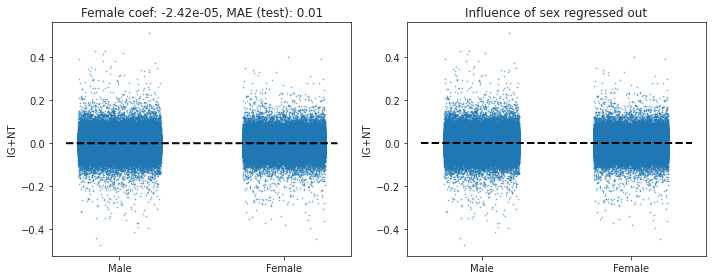

In [150]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
X = ignt['female'] + np.random.uniform(low=-0.25, high=0.25, size=(ignt.shape[0],))
ax[0].scatter(X, ignt['ig+nt'], s=0.5, alpha=0.5, rasterized=True)
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(['Male', 'Female'])
ax[0].set_ylabel('IG+NT')
ax[0].plot(ax[0].get_xlim(), [f(ax[0].get_xlim()[0]), f(ax[0].get_xlim()[1])], color='black', linewidth=2, linestyle='--')
ax[0].set_title('Female coef: {:.2e}, MAE (test): {:.2f}'.format(reg_lr.coef_.item(), np.mean(np.abs(reg_lr.predict(X_test) - y_test.squeeze()))))

# im = ax[1].scatter(X, ignt['adj_ignt'], c=ignt['change'].to_numpy(), cmap='RdYlBu_r', s=0.5, alpha=0.5, rasterized=True)
# fig.colorbar(im, ax=ax[1], label='Percent change')
ax[1].scatter(X, ignt['adj_ignt'], s=0.5, alpha=0.5, rasterized=True)

ax[1].set_xticks([0,1])
ax[1].set_xticklabels(['Male', 'Female'])
ax[1].set_ylabel('IG+NT')
ax[1].plot(ax[0].get_xlim(), [reg_lr.intercept_, reg_lr.intercept_], color='black', linewidth=2, linestyle='--')
ax[1].set_title('Influence of sex regressed out')
fig.tight_layout()
fig.savefig(os.path.join(pfp, 'ignt_female_regressedout.pdf'), dpi=600, bbox_inches='tight')

# visualize

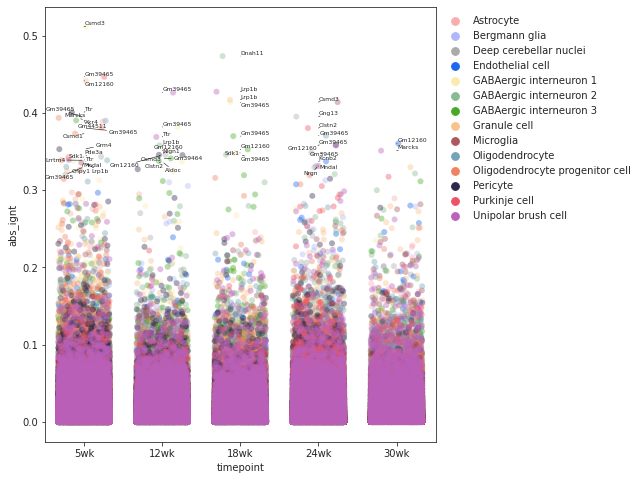

In [160]:
# visualize with categorical plot
dt = ignt.copy() # use full thing
if True:
    # drop mito, ribosomal, and MALAT1 genes
#     genes2exclude = [g for g in dt['Gene'] if 'mt-' in g or g.startswith('RPS') or g.startswith('RPL')] + ['MALAT1']
    genes2exclude = [g for g in dt['Gene'] if 'mt-' in g] + ['Malat1']
    dt = dt.loc[(~dt['Gene'].isin(genes2exclude)), :]
topn = 50
dt['abs_ignt'] = dt['adj_ignt'].abs()
topn_idx = dt.sort_values(by='abs_ignt', ascending=False).iloc[0:topn, :].index.to_list()    

fig, ax = plt.subplots(1,1, figsize=(7,8))

# dtt = dt.loc[dt['abs_ignt']>0.2, :]
# dtt=dtt.append(dt.loc[dt['abs_ignt']<=0.2, :].sample(100000))

p1 = sns.stripplot(
    x='timepoint',
    y='abs_ignt',
    hue='ctype',
    data=dt,
    order=['5wk','12wk','18wk','24wk','30wk'],
    hue_order=None,
    jitter=0.33,
    dodge=False,
    orient=None,
    color=None,
    palette=cmap_ctype,
    edgecolor='gray',
    linewidth=0,
    ax=ax,
    alpha=0.4,
    s=6,
    rasterized=True,
)

time2num = {k:i for i, k in enumerate(['5wk','12wk','18wk','24wk','30wk'])}
ax.legend(bbox_to_anchor=(1,1))
texts = [ax.text(time2num[dt.loc[ii, 'timepoint']], dt.loc[ii, 'abs_ignt'], dt.loc[ii, 'Gene'], fontsize=6) for ii in topn_idx]
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5), ax=ax)


fig.savefig(os.path.join(pfp, 'female_adj_abs_ignt_pertimepoint_test7p.pdf'), bbox_inches='tight', dpi=600)






In [156]:
# save, send to leon 
ignt.to_csv(os.path.join(pfp, 'ignt_7ptest_revision.csv'))

In [163]:
ignt['abs_adjignt'] = ignt['adj_ignt'].abs()
ignt = ignt.sort_values(by='abs_adjignt', ascending=False)
ignt.to_csv(os.path.join(pfp, 'ignt_7ptest_revision.csv'))

In [165]:
?sc.external.pp.scrublet

Signature:
sc.external.pp.scrublet(
    adata: anndata._core.anndata.AnnData,
    adata_sim: Union[anndata._core.anndata.AnnData, NoneType] = None,
    sim_doublet_ratio: float = 2.0,
    expected_doublet_rate: float = 0.05,
    stdev_doublet_rate: float = 0.02,
    synthetic_doublet_umi_subsampling: float = 1.0,
    knn_dist_metric: str = 'euclidean',
    normalize_variance: bool = True,
    log_transform: bool = False,
    mean_center: bool = True,
    n_prin_comps: int = 30,
    use_approx_neighbors: bool = True,
    get_doublet_neighbor_parents: bool = False,
    n_neighbors: Union[int, NoneType] = None,
    threshold: Union[float, NoneType] = None,
    verbose: bool = True,
    copy: bool = False,
    random_state: int = 0,
) -> Union[anndata._core.anndata.AnnData, NoneType]
Docstring:
Predict doublets using Scrublet [Wolock19]_.

Predict cell doublets using a nearest-neighbor classifier of observed
transcriptomes and simulated doublets. Works best if the input is a raw
(unnormali